# 基础函数定义

In [1]:
VER = 1
import pandas as pd, numpy as np
import pickle, glob, gc

from collections import Counter
import itertools
import os
import time
from tqdm import tqdm
from datetime import datetime
import dask.dataframe as dd

# multiprocessing
import psutil
N_CORES = min(psutil.cpu_count(),32)     # Available CPU cores
print(f"N Cores : {N_CORES}")
from multiprocessing import Pool
import shutil
import gensim
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=N_CORES)

CHUNK_NUM = 5

N Cores : 32
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
type_labels = {'clicks':0, 'carts':1, 'orders':2}
def reduce_mem(df):
    starttime = time.time()
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        print(f"{col} type is {col_type}")
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if pd.isnull(c_min) or pd.isnull(c_max):
                continue
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('-- Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction),time spend:{:2.2f} min'.format(end_mem,100*(start_mem-end_mem)/start_mem,(time.time()-starttime)/60))
    return df

def load_files(files):  
    dfs = []
    for e, chunk_file in enumerate(glob.glob(files)):
        chunk = pd.read_parquet(chunk_file)
        chunk.ts = (chunk.ts/1000).astype('int32')
        chunk.session = chunk.session.astype('int32')
        chunk.aid = chunk.aid.astype('int32')
        chunk['type'] = chunk['type'].map(type_labels).astype('int8')
        dfs.append(chunk)
    return pd.concat(dfs).reset_index(drop=True)

def save_parquet(df,folder,name):
    if folder=="":
        folder="./"
    else:
        folder=f"./{folder}"
    if not os.path.exists(folder):
        os.mkdir(folder)
    df.to_parquet(f"{folder}/{name}.pqt")
    print(f"Save file name = {folder}/{name}.pqt")

def df_parallelize_run(func, t_split):
    num_cores = np.min([N_CORES, len(t_split)])
    pool = Pool(num_cores)
    df = pool.map(func, t_split)
    pool.close()
    pool.join()
    
    return df

# Item feature



## feature函数定义

按如下格式输入

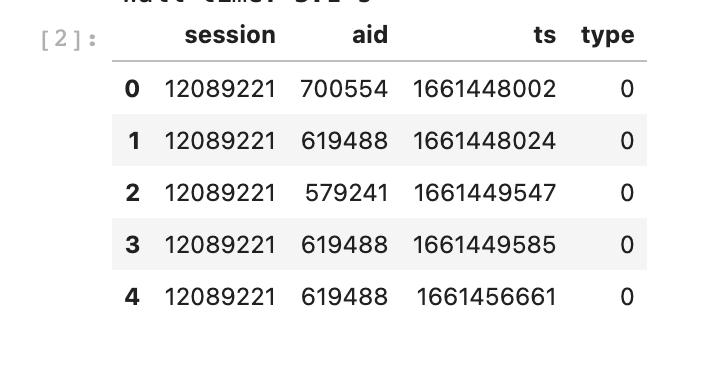

In [ ]:
def get_item_hotness_feature(df):
    """
    制作衡量热度的特征
    越小越热门
    """
    assert df.columns.values.tolist() == ['session', 'aid', 'ts', 'type']
    data =df.copy()
    article_hot = pd.DataFrame(data.sort_values(['aid', 'ts']).groupby('aid', as_index=False)[['session', 'ts']].\
                               agg({'session':np.size, 'ts': {list}}).values, columns=['aid', 'item_user_num', 'ts'])
    
    # 计算被点击时间间隔的均值
    def time_diff_mean(l):
        if len(l) == 1:
            return 7*24*3600 # 时间间隔越大，活跃度越低==》只有一次交互应该是活跃度最低的
        else:
            return np.mean([j-i for i, j in list(zip(l[:-1], l[1:]))])
        
    article_hot['item_action_time_diff'] = article_hot['ts'].apply(lambda x: time_diff_mean(x))
    
    # 点击次数取倒数
    article_hot['item_user_num'] = 1 / article_hot['item_user_num']
    
    # 两者归一化
    article_hot['item_user_num'] = (article_hot['item_user_num'] - article_hot['item_user_num'].min()) \
            / (article_hot['item_user_num'].max() - article_hot['item_user_num'].min())
    article_hot['item_action_time_diff'] = (article_hot['item_action_time_diff'] - article_hot['item_action_time_diff'].min()) \
            / (article_hot['item_action_time_diff'].max() - article_hot['item_action_time_diff'].min())     
    article_hot['item_hotness'] = article_hot['item_user_num'] + article_hot['item_action_time_diff']
    
    article_hot['aid'] = article_hot['aid'].astype('int')
    
    del article_hot['ts']
    article_hot = article_hot.set_index('aid')
#     save_parquet(article_hot, 'item_feature', 'item_hotness_feature')
    
    return article_hot

In [ ]:
def get_item_action_feature(df):
    assert df.columns.values.tolist() == ['session', 'aid', 'type']
    data = df.copy()
    # 计算各个行为的去重用户数
    item_action_user_cnt = data.groupby(['aid','type']).session.nunique().to_frame().reset_index()
    item_action_user_cnt = item_action_user_cnt.pivot_table(index=['aid'], columns='type',values='session')\
        .fillna(0).rename_axis(None, axis=1)\
        .rename(columns={0:'item_click_uni_user_cnt',1:'item_cart_uni_user_cnt',2:'item_order_uni_user_cnt'})

    # 计算各个行为的总交互数
    item_action_cnt = data.groupby(['aid','type']).session.count().to_frame().reset_index()
    item_action_cnt = item_action_cnt.pivot_table(index=['aid'], columns='type',values='session')\
        .fillna(0).rename_axis(None, axis=1)\
        .rename(columns={0:'item_click_cnt',1:'item_cart_cnt',2:'item_order_cnt'})

    # 计算各个行为的交互率
    item_action_cnt['item_cart_ratio'] = item_action_cnt.item_cart_cnt/(item_action_cnt.item_click_cnt+1) # 避免除0
    item_action_cnt['item_order_ratio'] = item_action_cnt.item_order_cnt/(item_action_cnt.item_cart_cnt+1) # 避免除0
    item_action_cnt = item_action_cnt.fillna(0)

    # 拼接
    item_action_feature = item_action_cnt.merge(item_action_user_cnt,\
                                left_index=True,right_index=True,\
                                how='left')
    # 保存
#     save_parquet(item_action_feature,'item_feature','item_action_feature')
    return item_action_feature

In [ ]:
def get_item_time_feature(df):
    '''
    平均DoW, HoD
    '''
    assert df.columns.values.tolist() == ['session', 'aid', 'ts', 'type']
    data = df.copy()
    
    # 聚合
    data['DoW'] = data.ts.apply(lambda x:datetime.fromtimestamp(x).weekday()).astype('int8')
    data['HoD'] = data.ts.apply(lambda x:datetime.fromtimestamp(x).hour).astype('int8')

    # 求均值
    DoW_mean = data.groupby(['aid']).DoW.mean().to_frame()
    HoD_mean = data.groupby(['aid']).HoD.mean().to_frame()
    item_time_feature = DoW_mean.merge(HoD_mean, left_index=True,right_index=True,how='left')\
        .rename(columns={'DoW':'item_avg_DoW','HoD':'item_avg_HoD'})
    
    # 求item在各个时段活跃度
    type_weight = {0: 1, 1: 6, 2: 3}
    data['weight'] = data['type'].apply(lambda x:type_weight[x]).astype('int32')
    item_weight_by_DoW = data.groupby(['aid','DoW']).weight.sum().to_frame()
    item_weight_by_DoW = item_weight_by_DoW.pivot_table(index=['aid'], columns='DoW',values='weight').fillna(0).rename_axis(None, axis=1)\
                        .add_prefix('item_hotness_on_DoW_')
    item_time_feature = item_time_feature.merge(item_weight_by_DoW,left_index=True,right_index=True,how='left')

    item_weight_by_HoD = data.groupby(['aid','HoD']).weight.sum().to_frame()
    item_weight_by_HoD = item_weight_by_HoD.pivot_table(index=['aid'], columns='HoD',values='weight').fillna(0).rename_axis(None, axis=1)\
                        .add_prefix('item_hotness_on_HoD_')
    item_time_feature = item_time_feature.merge(item_weight_by_HoD,left_index=True,right_index=True,how='left')
#     save_parquet(item_time_feature,'item_feature','item_time_feature')
    return item_time_feature
    

## 并行+分chunk执行

In [ ]:
# 分chunk提取feature
def calc_item_feature_by_chunk(func, df, folder, feat_name, chunk_num=10):
    for i,chunk in tqdm(enumerate(np.array_split(pd.DataFrame(df.aid.unique(),columns=['aid']), chunk_num))):
        item_base_chunk = df[df.aid.isin(chunk.aid)]

        # item feature
        # 将chunk分成N_CORES份进行并行执行
        t_splits = [item_base_chunk[item_base_chunk.aid.isin(chunk.aid)] for chunk in \
                np.array_split(pd.DataFrame(item_base_chunk.aid.unique(), columns=['aid']), N_CORES)]
        temp = df_parallelize_run(func, t_splits)
        item_features = pd.concat(temp)
        # item_features = func(item_base_chunk)
        save_parquet(item_features,"item_feature_chunk",f"{feat_name}_{i}")
        
        # 回收内存
        del item_features
        _ = gc.collect()
    
    # 重新读取进行拼接
    item_features = []
    for file in glob.glob(f"./item_feature_chunk/{feat_name}*"):
        item_features.append(pd.read_parquet(file))
    item_features = pd.concat(item_features)
    print(f"Get item feature shape = {item_features.shape}")
    save_parquet(item_features,folder,feat_name)
    
    # 清除现场
    shutil.rmtree('./item_feature_chunk')
    item_features.head()
    del item_features
    _ = gc.collect()

## val
阶段的item feature = train+valA

In [ ]:
%%time
validA = load_files('../input/otto-validation/test_parquet/*')
print('ValidA data has shape',validA.shape)
print(f"ValidA data user cnt = {validA.session.nunique()}")
print(f"ValidA data aid cnt = {validA.aid.nunique()}")

train = load_files('../input/otto-validation/train_parquet/*')
print('Train data has shape',train.shape)
print(f"Train data user cnt = {train.session.nunique()}")
print(f"Train data aid cnt = {train.aid.nunique()}")

# for item_feature calc
train_valA = pd.concat([train,validA])
print('train_valA data has shape',train_valA.shape)
print(f"train_valA data user cnt = {train_valA.session.nunique()}")
print(f"train_valA data aid cnt = {train_valA.aid.nunique()}")
train_valA.to_parquet("train_valA.pqt")
del train
_ = gc.collect()
train_valA.head()

In [ ]:
%%time
calc_item_feature_by_chunk(get_item_hotness_feature,
                           train_valA,'val',
                           'item_hotness_feature',chunk_num=CHUNK_NUM)
calc_item_feature_by_chunk(get_item_action_feature,
                           train_valA[['session', 'aid', 'type']],'val',
                           'item_action_feature',chunk_num=CHUNK_NUM)
calc_item_feature_by_chunk(get_item_time_feature,
                           train_valA,'val',
                           'item_time_feature',chunk_num=CHUNK_NUM)

# 聚合
item_hotness_feature = pd.read_parquet('./val/item_hotness_feature.pqt')
item_time_feature = pd.read_parquet('./val/item_time_feature.pqt')
item_action_feature = pd.read_parquet('./val/item_action_feature.pqt')
item_feature = pd.concat([item_hotness_feature,item_time_feature,item_action_feature],axis=1)
save_parquet(item_feature,'val','item_feature')
del item_hotness_feature,item_time_feature,item_action_feature,item_feature
_ = gc.collect()

## test
test阶段的item feature = train+valA+valB+test

In [ ]:
train = load_files("../input/otto-chunk-data-inparquet-format/train_parquet")
test = load_files("../input/otto-chunk-data-inparquet-format/test_parquet")
train_test = pd.concat([train,test])
del train,test
_ = gc.collect()
train_test.to_parquet("train_test.pqt")

In [ ]:
%%time
calc_item_feature_by_chunk(get_item_hotness_feature,
                           train_test,'test',
                           'item_hotness_feature',chunk_num=CHUNK_NUM)
calc_item_feature_by_chunk(get_item_action_feature,
                           train_test[['session', 'aid', 'type']],'test',
                           'item_action_feature',chunk_num=CHUNK_NUM)
calc_item_feature_by_chunk(get_item_time_feature,
                           train_test,'test',
                           'item_time_feature',chunk_num=CHUNK_NUM)

# 聚合
item_hotness_feature = pd.read_parquet('./test/item_hotness_feature.pqt')
item_time_feature = pd.read_parquet('./test/item_time_feature.pqt')
item_action_feature = pd.read_parquet('./test/item_action_feature.pqt')
item_feature = pd.concat([item_hotness_feature,item_time_feature,item_action_feature],axis=1)
save_parquet(item_feature,'test','item_feature')
del item_hotness_feature,item_time_feature,item_action_feature,item_feature
_ = gc.collect()

# User feature
user feature需要分别提取val阶段和test阶段

## feature函数定义

In [ ]:
def get_user_activeness_feature(df):
    """
    制作区分用户活跃度的特征
    越小越活跃
    """
    assert df.columns.values.tolist() == ['session', 'aid', 'ts', 'type']
    data = df.copy()
    data.sort_values(['session', 'ts'], inplace=True)
    user_activeness_feature = pd.DataFrame(data.groupby('session', as_index=False)[['aid', 'ts']].\
                            agg({'aid':np.size, 'ts': {list}}).values, columns=['session', 'user_click_size', 'ts'])
    
    # 计算时间间隔的均值
    def time_diff_mean(l):
        if len(l) == 1:
            return 7*24*3600
        else:
            return np.mean([j-i for i, j in list(zip(l[:-1], l[1:]))])
        
    user_activeness_feature['user_action_time_diff'] = user_activeness_feature['ts'].apply(lambda x: time_diff_mean(x))
    
    # 点击次数取倒数
    user_activeness_feature['user_click_size'] = 1 / user_activeness_feature['user_click_size']
    
    # 两者归一化
    user_activeness_feature['user_click_size'] = (user_activeness_feature['user_click_size'] - user_activeness_feature['user_click_size'].min()) \
        / (user_activeness_feature['user_click_size'].max() - user_activeness_feature['user_click_size'].min())
    user_activeness_feature['user_action_time_diff'] = (user_activeness_feature['user_action_time_diff'] - user_activeness_feature['user_action_time_diff'].min()) \
        / (user_activeness_feature['user_action_time_diff'].max() - user_activeness_feature['user_action_time_diff'].min())     
    user_activeness_feature['user_activeness'] = user_activeness_feature['user_click_size'] + user_activeness_feature['user_action_time_diff']
    
    user_activeness_feature['session'] = user_activeness_feature['session'].astype('int')
    del user_activeness_feature['ts']
    user_activeness_feature = user_activeness_feature.set_index('session')
    
#     save_parquet(user_activeness_feature, 'user_feature','user_activeness_feature')
    
    return user_activeness_feature

In [ ]:
def get_user_action_feature(df):
    assert df.columns.values.tolist() == ['session', 'aid', 'type']
    data = df.copy()
    # 计算各个行为的去重物品数
    user_action_item_cnt = data.groupby(['session','type']).aid.nunique().to_frame().reset_index()
    user_action_item_cnt = user_action_item_cnt.pivot_table(index=['session'], columns='type',values='aid')\
        .fillna(0).rename_axis(None, axis=1)\
        .rename(columns={0:'user_click_uni_item_cnt',1:'user_cart_uni_item_cnt',2:'user_order_uni_item_cnt'})

    # 计算各个行为的总交互数
    user_action_cnt = data.groupby(['session','type']).aid.count().to_frame().reset_index()
    user_action_cnt = user_action_cnt.pivot_table(index=['session'], columns='type',values='aid')\
        .fillna(0).rename_axis(None, axis=1)\
        .rename(columns={0:'user_click_cnt',1:'user_cart_cnt',2:'user_order_cnt'})

    # 计算各个行为的交互率
    user_action_cnt['user_cart_ratio'] = user_action_cnt.user_cart_cnt/(user_action_cnt.user_click_cnt+1)
    user_action_cnt['user_order_ratio'] = user_action_cnt.user_order_cnt/(user_action_cnt.user_cart_cnt+1)
    user_action_cnt = user_action_cnt.fillna(0)

    # 拼接
    user_action_feature = user_action_cnt.merge(user_action_item_cnt,\
                                left_index=True,right_index=True,\
                                how='left')
    # 保存
#     save_parquet(user_action_feature,'user_feature','user_action_feature')
    return user_action_feature

In [ ]:
def get_user_time_feature(df):
    '''
    平均DoW，HoD
    活跃情况
    '''
    assert df.columns.values.tolist() == ['session', 'aid', 'ts', 'type']
    data = df.copy()
    
    # 聚合DoW和HoD
    data['DoW'] = data.ts.apply(lambda x:datetime.fromtimestamp(x).weekday())
    data['HoD'] = data.ts.apply(lambda x:datetime.fromtimestamp(x).hour)

    # 求均值
    DoW_mean = data.groupby(['session']).DoW.mean().to_frame()
    HoD_mean = data.groupby(['session']).HoD.mean().to_frame()
    user_time_feature = DoW_mean.merge(HoD_mean, left_index=True,right_index=True,how='left')\
        .rename(columns={'DoW':'user_avg_DoW','HoD':'user_avg_HoD'})
    user_time_feature.user_avg_DoW = user_time_feature.user_avg_DoW.astype('int8')
    user_time_feature.user_avg_HoD = user_time_feature.user_avg_HoD.astype('int8')
    
    # 活跃情况
    user_time_feature['user_last_DoW'] = data.groupby('session').ts.max()\
        .apply(lambda x:datetime.fromtimestamp(x).weekday()).astype('int8')
    user_time_feature['user_first_DoW'] = data.groupby('session').ts.max()\
        .apply(lambda x:datetime.fromtimestamp(x).weekday()).astype('int8')

    # 活跃时长
    user_time_feature['user_active_seconds'] = data.groupby('session').ts\
        .agg(lambda x:(max(x)-min(x))).astype('int32')
    user_time_feature['user_active_minutes'] = user_time_feature['user_active_seconds']//60
    user_time_feature['user_active_hours'] = user_time_feature['user_active_seconds']//3600
    user_time_feature['user_active_days'] = user_time_feature['user_active_seconds']//86400

#     save_parquet(user_time_feature,'user_feature','user_time_feature')
    return user_time_feature

In [ ]:
def get_user_real_session_feature(df):
    '''
    real session定义参考 https://www.kaggle.com/competitions/otto-recommender-system/discussion/366138
    real session数
    real session平均交互item数目
    real session分type平均交互item数目
    real session时长
    real session内click间隔
    '''
    assert df.columns.values.tolist() == ['session', 'aid', 'ts', 'type']
    data = df.copy()
    
    # 划分为不同real session
    data = data.sort_values(['session','ts'])
    data['diff'] = data.groupby('session').ts.diff()
    data['real_session'] = (data['diff'] > 60*60*1).astype('int8').fillna(0)
    data['real_session'] = data.groupby('session').real_session.cumsum()

    # 计算总real session数
    user_real_session_feature = data.groupby('session').real_session.max().to_frame()

    # 计算user所有real session内的平均item数目
    data['user_real_session_item_cnt'] = data.groupby(['session','real_session']).aid.transform('count')
    temp = data.groupby(['session','real_session']).user_real_session_item_cnt.mean().to_frame()
    user_real_session_feature['user_real_session_avg_item_cnt'] = temp.groupby('session').user_real_session_item_cnt.mean().astype('int32')

    # 计算user所有real session内各个type的平均item数目
    temp = data.groupby(['session','real_session','type']).aid.nunique().to_frame()
    temp = temp.pivot_table(index=['session','real_session'], columns='type',values='aid')\
            .fillna(0).rename_axis(None, axis=1).groupby(['session']).mean()\
            .rename(columns={0:'user_real_session_avg_click',1:'user_real_session_avg_cart',2:'user_real_session_avg_order'})
    user_real_session_feature = user_real_session_feature.merge(temp,left_index=True,right_index=True,how='left')
    del user_real_session_feature['real_session']
    
    # 计算user所有real session的平均时长(单位秒)
    temp = (data.groupby(['session','real_session']).ts.max()-data.groupby(['session','real_session']).ts.min()).to_frame()
    user_real_session_feature['user_real_session_avg_duration'] = temp.groupby('session').ts.mean().astype('float32').fillna(0)

    # 计算user所有real session内click的平均间隔(单位秒)
    temp = data[(data.type==0) & (data['diff']<2*3600)].groupby(['session','real_session'])['diff'].mean().to_frame()
    user_real_session_feature['user_real_session_avg_click_diff'] = temp.groupby('session')['diff'].mean().astype('float32')
    user_real_session_feature['user_real_session_avg_click_diff'] = user_real_session_feature['user_real_session_avg_click_diff'].fillna(30*24*3600)
    
#     save_parquet(user_real_session_feature,'user_feature','user_real_session_feature')
    return user_real_session_feature

## 并行+分chunk执行

In [ ]:
# 分chunk提取feature
def calc_user_feature_by_chunk(func, df, folder, feat_name, chunk_num=10):
    for i,chunk in tqdm(enumerate(np.array_split(pd.DataFrame(df.session.unique(),columns=['session']), chunk_num))):
        user_base_chunk = df[df.session.isin(chunk.session)]

        # user feature
        # 将chunk分成N_CORES份进行并行执行
        t_splits = [user_base_chunk[user_base_chunk.session.isin(chunk.session)] for chunk in \
                np.array_split(pd.DataFrame(user_base_chunk.session.unique(), columns=['session']), N_CORES)]
        temp = df_parallelize_run(func, t_splits)
        user_features = pd.concat(temp)
        save_parquet(user_features,"user_feature_chunk",f"{feat_name}_{i}")
        
        # 回收内存
        del user_features
        _ = gc.collect()
    
    # 重新读取进行拼接
    user_features = []
    for file in glob.glob(f"./user_feature_chunk/{feat_name}*"):
        user_features.append(pd.read_parquet(file))
    user_features = pd.concat(user_features)
    print(f"Get user feature shape = {user_features.shape}")
    save_parquet(user_features,folder,feat_name)
    
    # 清除现场
    shutil.rmtree('./user_feature_chunk')
    user_features.head()
    del user_features
    _ = gc.collect()

## val

In [ ]:
# 读取val用户数据
validA = load_files('../input/otto-validation/test_parquet/*')
print('ValidA data has shape',validA.shape)
print(f"ValidA data user cnt = {validA.session.nunique()}")
print(f"ValidA data aid cnt = {validA.aid.nunique()}")

In [ ]:
%%time
calc_user_feature_by_chunk(get_user_activeness_feature,
                           validA,'val',
                           'user_activeness_feature',chunk_num=CHUNK_NUM)
calc_user_feature_by_chunk(get_user_time_feature,
                           validA,'val',
                           'user_time_feature',chunk_num=CHUNK_NUM)
calc_user_feature_by_chunk(get_user_real_session_feature,
                           validA,'val',
                           'user_real_session_feature',chunk_num=CHUNK_NUM)
calc_user_feature_by_chunk(get_user_action_feature,
                           validA[['session', 'aid', 'type']],'val',
                           'user_action_feature',chunk_num=CHUNK_NUM)

# 聚合
user_activeness_feature = pd.read_parquet('./val/user_activeness_feature.pqt')
user_time_feature = pd.read_parquet('./val/user_time_feature.pqt')
user_real_session_feature = pd.read_parquet('./val/user_real_session_feature.pqt')
user_action_feature = pd.read_parquet('./val/user_action_feature.pqt')
user_feature = pd.concat([user_activeness_feature,user_time_feature,user_real_session_feature,user_action_feature],axis=1)
save_parquet(user_feature,'val','user_feature')
del user_action_feature,user_activeness_feature,user_real_session_feature,user_time_feature,user_feature
_ = gc.collect()

## test

In [ ]:
# 读入test用户data
test = load_files("../input/otto-chunk-data-inparquet-format/test_parquet/*")
print('test data has shape',test.shape)
print(f"test data user cnt = {test.session.nunique()}")
print(f"test data aid cnt = {test.aid.nunique()}")

In [ ]:
%%time
calc_user_feature_by_chunk(get_user_activeness_feature,
                           test,'test',
                           'user_activeness_feature',chunk_num=CHUNK_NUM)
calc_user_feature_by_chunk(get_user_time_feature,
                           test,'test',
                           'user_time_feature',chunk_num=CHUNK_NUM)
calc_user_feature_by_chunk(get_user_real_session_feature,
                           test,'test',
                           'user_real_session_feature',chunk_num=CHUNK_NUM)
calc_user_feature_by_chunk(get_user_action_feature,
                           test[['session', 'aid', 'type']],'test',
                           'user_action_feature',chunk_num=CHUNK_NUM)

# 聚合
user_activeness_feature = pd.read_parquet('./test/user_activeness_feature.pqt')
user_time_feature = pd.read_parquet('./test/user_time_feature.pqt')
user_real_session_feature = pd.read_parquet('./test/user_real_session_feature.pqt')
user_action_feature = pd.read_parquet('./test/user_action_feature.pqt')
user_feature = pd.concat([user_activeness_feature,user_time_feature,user_real_session_feature,user_action_feature],axis=1)
save_parquet(user_feature,'test','user_feature')
del user_action_feature,user_activeness_feature,user_real_session_feature,user_time_feature,user_feature
_ = gc.collect()

# User * Item feature

## feature函数定义

In [ ]:
def get_ui_action_feature(df,candidate_file):
    '''
    各个交互次数
    '''
    candidate = pd.read_parquet(candidate_file)
    ui_action = candidate.merge(df,on=['session','aid'],how='left')
    
    ui_action = df.groupby(['session','aid','type']).count().rename(columns={'ts':'action_cnt'})

    ui_action = ui_action.pivot_table(index=['session','aid'], columns='type',values='action_cnt')\
        .rename(columns={0:'ui_clicks_cnt',1:'ui_cart_cnt',2:'ui_order_cnt'}).fillna(0).rename_axis(None, axis=1)
    ui_action = df.merge(ui_action,left_on=['session','aid'],right_index=True,how='left')
    ui_action = ui_action.astype('int32')

    del ui_action['ts'], ui_action['type']
    return ui_action

In [ ]:
def get_ui_similarity(df,candidate_file,model_file):
    '''
    计算用户当前推荐的candidate与用户历史上交互过item的相似度 基于word2vec
    df: 历史交互
    '''
    model = gensim.models.Word2Vec.load(model_file)
    type_weights = {0:1,1:6,2:3}

    # 准备数据
    user_history = df.groupby('session').agg(list)
    user_history.columns = ['history_items','ts','type']
    candidates = pd.read_parquet(candidate_file)
    data = user_history.merge(candidates,left_index=True,right_index=True,how='left')
    data = data.reset_index().rename(columns={'index':'session'})
    # 最终格式
    # session | aid | history_items_list | ts_list | type_list

    def calc_sim(row):
        cand = row.aid
        ts = np.array(row.ts)
        labels = row.type
        label_weights = np.array(list(map(lambda x:type_weights[x],labels)))
        time_weights = (ts-ts.min())/(ts.max()-ts.min()+1) if ts.shape[0]>1 else np.array([1])
        weights = time_weights*label_weights
        def get_sim(w1,w2):
            w1 = str(int(float(w1)))
            w2 = str(int(float(w2)))
            try:
                return model.wv.similarity(w1,w2)
            except Exception as e:
                print(f'Error at sim {e}')
                return 0
        sim = np.sum(np.array([get_sim(cand,hist_item) for hist_item in row.history_items])*weights)/np.sum(weights)
        row['weighted_similarity'] = sim
        return row
    data = data.parallel_apply(calc_sim,axis=1)
    return data[['session','aid','weighted_similarity']]

## 执行

## val

In [ ]:
# 读取val用户数据
train_valA = pd.read_parquet("train_valA.pqt")

In [ ]:
%%time
save_parquet(get_ui_action_feature(train_valA,
                                    candidate_file="../recall/val/orders_exploded_candidates.pqt"),
            'val','ui_action_feature')
save_parquet(get_ui_similarity(train_valA,
                                candidate_file="../recall/val/orders_exploded_candidates.pqt",
                                model_file = '../word2vec/train_word2vec.model'),
            'val','ui_similarity_feature')

# 聚合
ui_action_feature = pd.read_parquet('./val/ui_action_feature.pqt')
ui_similarity_feature = pd.read_parquet('./val/ui_similarity_feature.pqt')
ui_feature = pd.concat([ui_action_feature,ui_similarity_feature],axis=1)
save_parquet(ui_feature,'val','ui_feature')
del ui_action_feature,ui_similarity_feature,ui_feature
_ = gc.collect()

## test

In [ ]:
# 读入test用户data
train_test = pd.read_parquet('./train_test.pqt')

In [ ]:
%%time
save_parquet(get_ui_action_feature(train_test,
                                    candidate_file="../recall/test/orders_exploded_candidates.pqt"),
            'test','ui_action_feature')
save_parquet(get_ui_similarity(train_test,
                                candidate_file="../recall/test/orders_exploded_candidates.pqt",
                                model_file = '../word2vec/test_word2vec.model'),
            'test','ui_similarity_feature')

# 聚合
ui_action_feature = pd.read_parquet('./test/ui_action_feature.pqt')
ui_similarity_feature = pd.read_parquet('./test/ui_similarity_feature.pqt')
ui_feature = pd.concat([ui_action_feature,ui_similarity_feature],axis=1)
save_parquet(ui_feature,'test','ui_feature')
del ui_action_feature,ui_similarity_feature,ui_feature
_ = gc.collect()

# 拼接

In [ ]:
# 拼接上label
def concat_label(train_set,label_file_name):
    # labels
    labels = pd.read_parquet(label_file_name)

    # clicks
    target = labels.loc[labels['type']=='clicks']
    aids = target.ground_truth.explode().astype('int32').rename('aid')
    target = target[['session']].astype('int32')
    target = target.merge(aids, left_index=True, right_index=True, how='left')
    target['clicks'] = 1
    train_set = train_set.merge(target,on=['session','aid'],how='left').fillna(0)

    # carts
    target = labels.loc[labels['type']=='carts']
    aids = target.ground_truth.explode().astype('int32').rename('aid')
    target = target[['session']].astype('int32')
    target = target.merge(aids, left_index=True, right_index=True, how='left')
    target['carts'] = 1
    train_set = train_set.merge(target,on=['session','aid'],how='left').fillna(0)

    # orders
    target = labels.loc[labels['type']=='orders']
    aids = target.ground_truth.explode().astype('int32').rename('aid')
    target = target[['session']].astype('int32')
    target = target.merge(aids, left_index=True, right_index=True, how='left')
    target['orders'] = 1
    train_set = train_set.merge(target,on=['session','aid'],how='left').fillna(0)
    
    print(f"Load data shape = {train_set.shape}, mem usage = {int(train_set.memory_usage().sum() / 1024**2)} MB")
    train_set.head(10)
    return train_set

# features
def concat_feature(candidate,feature_filename,merge_on='aid',fill_with=-1):
    print(f'Concating {feature_filename}...')
    feature = dd.from_pandas(pd.read_parquet(feature_filename),npartitions=16)
    df = dd.merge(candidate, feature, on=merge_on, how='left').compute().fillna(fill_with)
    del feature
    _ = gc.collect()
    print(f"Concated shape = {df.shape}, mem usage = {int(df.memory_usage().sum() / 1024**2)} MB")
    return df

## train

拼接一个包含clicks，orders，carts三种类型数据的train_set

In [ ]:
%%time
candidate_file = "../recall/val/orders_exploded_candidates.pqt"
label_file_name = '../input/otto-validation/test_labels.parquet'
# load data
candidates = pd.read_parquet(candidate_file).rename_axis('session').reset_index()
train_set = concat_label(candidates,label_file_name)
train_set = dd.from_pandas(train_set,npartitions=N_CORES)
del candidates
_ = gc.collect()

# feature
# item_feature_filenames = glob.glob('./val/item_*')
# user_feature_filenames = glob.glob('./val/user_*')
# ui_feature_filenames = glob.glob('./val/ui_*')
# print(f"item_feature_filenames = {item_feature_filenames}")
# print(f"user_feature_filenames = {user_feature_filenames}")
# print(f"ui_feature_filenames = {ui_feature_filenames}")
# train_set_with_item_feature = train_set.copy()
# for feature_filename in item_feature_filenames:
#     train_set_with_item_feature = concat_feature(train_set_with_item_feature,feature_filename,merge_on='aid')

# train_set_with_user_feature = train_set.copy()
# for feature_filename in user_feature_filenames:
#     train_set_with_user_feature = concat_feature(train_set_with_user_feature,feature_filename,merge_on='session')

# train_set_with_ui_feature = train_set.copy()
# for feature_filename in ui_feature_filenames:
#     train_set_with_ui_feature = concat_feature(train_set_with_ui_feature,feature_filename,merge_on=['session','aid'],fill_with=0)

feature_filename = './val/item_feature.pqt'
train_set = concat_feature(train_set,feature_filename,merge_on='aid')
feature_filename = './val/user_feature.pqt'
train_set = concat_feature(train_set,feature_filename,merge_on='session')
feature_filename = './val/ui_feature.pqt'
train_set = concat_feature(train_set,feature_filename,merge_on=['session','aid'])

assert train_set.session.nunique()==1801251,"用户数错误！"

# train set order for ranker
train_set = train_set.sort_values('session').reset_index(drop=True)

train_set.to_parquet(f"train_with_feature.pqt")
print(f"Get Train_set user cnt = {train_set.session.nunique()}; shape = {train_set.shape}")
train_set.head(10)
del train_set
_ = gc.collect()

In [5]:
%%time
train_with_feature = pd.read_parquet('train_with_feature.pqt')
train_with_feature[['session','aid']] = train_with_feature[['session','aid']].astype('int32')
ui_action_feature = pd.read_parquet('./val/ui_action_feature.pqt')
new_train_with_feature = train_with_feature.merge(ui_action_feature,on=['session','aid'],how='left').fillna(0)
new_train_with_feature.to_parquet('new_train_with_feature.pqt')


CPU times: user 2min 27s, sys: 3min 3s, total: 5min 31s
Wall time: 5min 32s


## test

In [ ]:
candidate_file = "../recall/test/orders_exploded_candidates.pqt"
# load data
test_set = pd.read_parquet(candidate_file).rename_axis('session').reset_index()
test_set = dd.from_pandas(test_set,npartitions=N_CORES)
print(f"Loaded test_set shape = {test_set.shape}")

# feature
# item_feature_filenames = glob.glob('./test/item_*')
# user_feature_filenames = glob.glob('./test/user_*')
# ui_feature_filenames = glob.glob('./test/ui_*')
# print(f"item_feature_filenames = {item_feature_filenames}")
# print(f"user_feature_filenames = {user_feature_filenames}")
# print(f"ui_feature_filenames = {ui_feature_filenames}")
# for feature_filename in item_feature_filenames:
#     test = concat_feature(test,feature_filename,merge_on='aid')
# for feature_filename in user_feature_filenames:
#     test = concat_feature(test,feature_filename,merge_on='session')
# for feature_filename in ui_feature_filenames:
#     test = concat_feature(test,feature_filename,merge_on=['session','aid'],fill_with=0)

feature_filename = './test/item_feature.pqt'
test_set = concat_feature(test_set,feature_filename,merge_on='aid')
feature_filename = './test/user_feature.pqt'
test_set = concat_feature(test_set,feature_filename,merge_on='session')
feature_filename = './test/ui_feature.pqt'
test_set = concat_feature(test_set,feature_filename,merge_on=['session','aid'])
assert test_set.session.nunique()==1671803,"用户数错误！"

# train set order for ranker
test_set = test_set.sort_values('session').reset_index(drop=True)

test_set.to_parquet(f"test_with_feature.pqt")
print(f"Get test_set user cnt = {test_set.session.nunique()}; shape = {test_set.shape}")
test_set.head(10)
del test_set
_ = gc.collect()

In [11]:
%%time
test_with_feature = pd.read_parquet('test_with_feature.pqt')
test_with_feature[['session','aid']] = test_with_feature[['session','aid']].astype('int32')
ui_action_feature = pd.read_parquet('./test/ui_action_feature.pqt')
new_test_with_feature = test_with_feature.merge(ui_action_feature,on=['session','aid'],how='left').fillna(0)
new_test_with_feature.to_parquet('new_test_with_feature.pqt')